### An attempt at reproducing Min's results

In [1]:
tab_fig_path='/burg/biostats/users/ek3235/RCTcontamination/contamiation_in_rct/tables_and_figures/'

In [2]:
source('utils.r') # heritable functions. Add plot functions later

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: foreach

Loading required package: iterators



In [3]:
# calculate sample size for specitific type I and II errors and effect size. 
n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)

# calculate power from fixed sample size 
pwr.func(n=400, 
        m1=1.0,
        m2=1.2,
        sd=1,
        type_I_error=0.05)

[1] 0.8074296

$\textbf{2. Randomize to treatment then assign to doctors in a controlled fashion}$

That is, randomize such that each doctor gets equal number of intervetion and control patients.

In [4]:
# Randomize to treatment but assign to clusters in a controlled manner as described above

options(scipen=999)
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=400 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)


# Randomize patients to treatment 
trt=rbinom(n=N,size=1, prob=0.5)

trt=sort(trt) # sort 

## Assign to clusters in a controlled fashion. 
cluster.assigment=c( rep(1:k, each=ni/k ), rep(1:k, each=ni/k ))

# # x-beta 
xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

# # simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

# # generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

# # combine into a dataframe 

clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                    cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

head(clust.df)

# sanity checks
table(cluster.assigment, trt)

t.test(y~trt, data=clust.df)$p.value

,y,trt,cluster.assigned,cluster_random_interc
,<dbl>,<int>,<int>,<dbl>
1,0.3348689,0,1,0.2003752
2,-0.9104812,0,1,0.2003752
3,-0.2449106,0,1,0.2003752
4,-0.7243004,0,1,0.2003752
5,0.8415747,0,1,0.2003752
6,1.2453127,0,1,0.2003752


                 trt
cluster.assigment  0  1
               1  43 37
               2  40 40
               3  40 40
               4  40 40
               5  40 40
               6  40 40
               7  40 40
               8  40 40
               9  40 40
               10 40 40

[1] 0.08775995

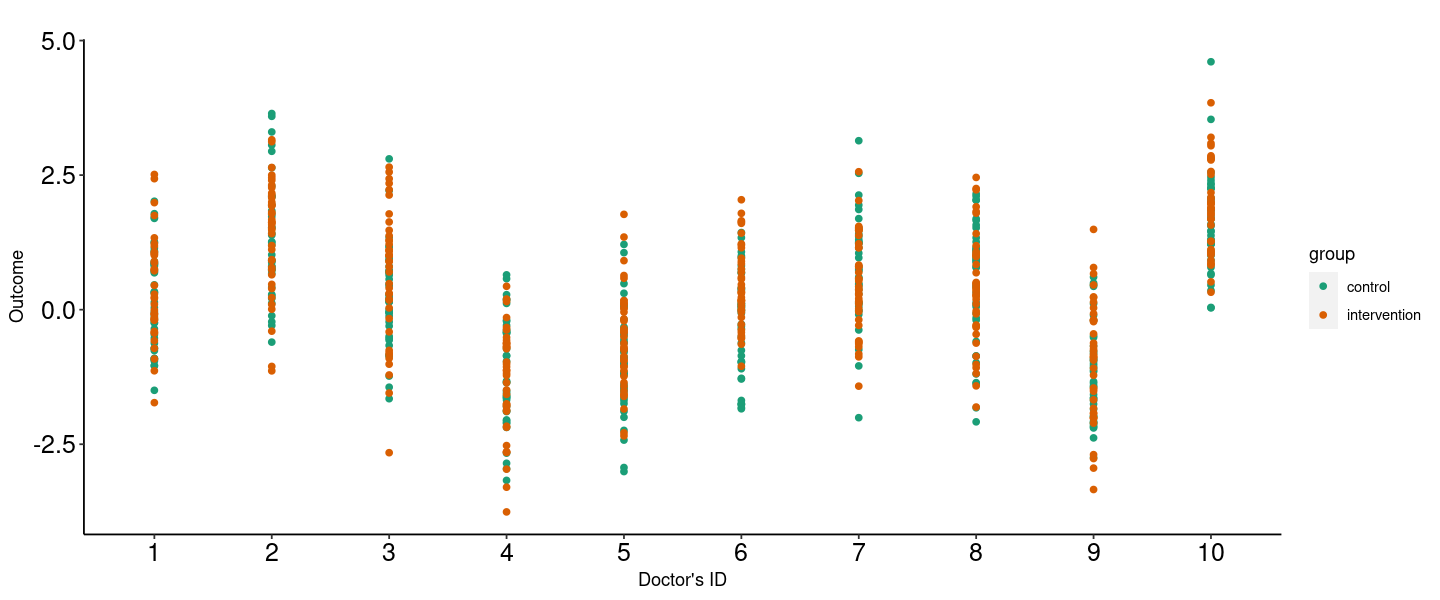

In [5]:
clust.df$cluster.assigned=as.factor(clust.df$cluster.assigned)
clust.df$group=ifelse(clust.df$trt==1, 'intervention', 'control')
                      
options(repr.plot.width = 12, repr.plot.height =5) 

plot.overall=ggplot(clust.df, aes(x=cluster.assigned, y=y, group=group)  )+
geom_point(aes(color=group))+scale_color_brewer(palette="Dark2")+
ylim( min(clust.df$y), max(clust.df$y))+
labs(x="Doctor's ID",y="Outcome")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0), 
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( '' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.overall

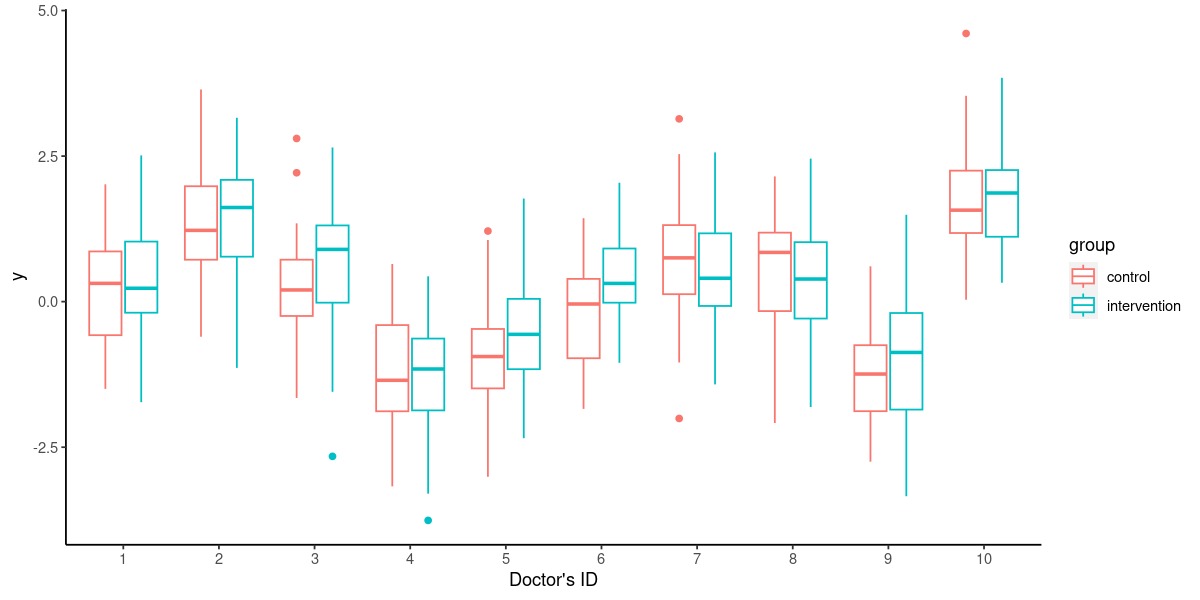

In [6]:
options(repr.plot.width = 10, repr.plot.height =5) 
box.p=ggplot(clust.df, aes(x=cluster.assigned, y=y, color=group)) + 
labs(x="Doctor's ID",y="y")+
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

box.p

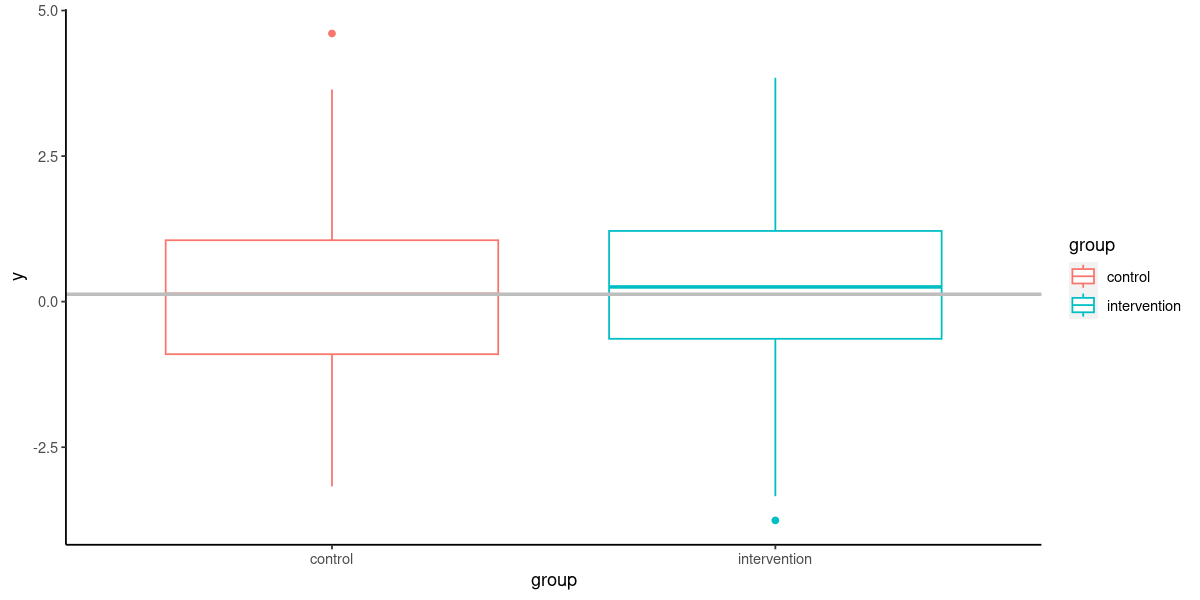

In [7]:
# check if intervention is different from control if we ignore cluster variable. 
options(repr.plot.width = 10, repr.plot.height =5) 
box.p=ggplot(clust.df, aes(x=group, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==0] ), color = "grey", linewidth=1)

box.p

In [8]:
icc.from.tau=function(sigma_b){
    return( round( sigma_b/(sigma_b+sigma_e), 2  ) )
}

sigma_b.vec=matrix( c(0, 1, 1.5, 2), nrow=1)

icc.vec=apply(X=sigma_b.vec, MARGIN=2, FUN=icc.from.tau)
icc.vec

[1] 0.00 0.50 0.60 0.67

In [9]:
# check the impact of increasing tau on power 
sig.ind=NULL
pwr.icc=NULL
nsim=1000
k=100
ni=400
N=ni*2
for(ix in 1:length(icc.vec)){
    
    icc=icc.vec[ix]
    sigma_b=icc*sigma_e/(1-icc)
    #print(sigma_b)

    # Randomize patients to treatment 
    for (id in 1:nsim){
    trt=rbinom(n=N,size=1, prob=0.5)

    trt=sort(trt) # sort 

    ## Assign to clusters in a controlled fashion. 
    cluster.assigment=c( rep(1:k, each=ni/k ), rep(1:k, each=ni/k ))

    # # x-beta 
    xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

    # # simulate cluster random intercept (for now)  
    clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

    clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

    # # generate outcome variable yijk using equation in model 1. 
    y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

    # # combine into a dataframe 

    clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                        cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

    sig.ind[id]=t.test(y~trt, data=clust.df)$p.value<0.05 }# check if significant. 
    pwr.icc[ix]=sum(sig.ind)/nsim
}

pwr.icc

[1] 0.805 0.528 0.268 0.118

$\textbf{Findings}$

Again, the estimated treatment effect is not affected under this 'factorial  design' way of assigning patients to clusters. It only affects the its variance. 

It is also clear that there is doctor's effect that can be captured via a random intercept. But there is no interaction between a doctor and the treatment variable. So, there is no need for the random slope. Of course this is expected because of the structure of the data-generating model. 

$\textbf{3. Randomize clusters to treatments}$

In [10]:
# Conduct cluster randomization and generate the correspond data according to model 1
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)

k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=500 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.9   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1
sigma_b=icc*sigma_e/(1-icc)

N=ni*2

# Generate cluster id 
cluster.assigment=sample(x=1:k,size=N, replace=TRUE)

# Randomize treatment to the k clusters. 
trt.cluster=rbinom(n=k,size=1, prob=0.5) 

trt=trt.cluster[cluster.assigment] # assign each cluster to its appropriate treatment. 

xb=beta*trt

# simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 


# generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.vec

# combine into a dataframe 

clust.df=data.frame(y=y, trt=trt, cluster.assigned=cluster.assigment, cluster_random_interc=clust.vec) # add icc, number of clusters at a later date. 

# sanity checks. 
table(cluster.assigment, trt) # make sure that no cluster has both intervention and control. 
table(cluster.assigment)
trt.cluster

                 trt
cluster.assigment   0   1
               1   87   0
               2    0 112
               3    0 101
               4    0 124
               5    0  95
               6   91   0
               7  102   0
               8    0  92
               9  109   0
               10  87   0

cluster.assigment
  1   2   3   4   5   6   7   8   9  10 
 87 112 101 124  95  91 102  92 109  87 

[1] 0 1 1 1 1 0 0 1 0 0

In [11]:
# check the impact of increasing tau on power 
sig.ind=NULL
pwr.icc=NULL
nsim=1000
k=100
ni=400
N=ni*2
for(ix in 1:length(icc.vec)){
    
    icc=icc.vec[ix]
    
    sigma_b=icc*sigma_e/(1-icc)
    #print(sigma_b)

    # Randomize patients to treatment 
    for (id in 1:nsim){
    # Generate cluster id 
    cluster.assigment=sample(x=1:k,size=N, replace=TRUE)

    # Randomize treatment to the k clusters. 
    trt.cluster=rbinom(n=k,size=1, prob=0.5) 

    trt=trt.cluster[cluster.assigment] # assign each cluster to its appropriate treatment. 

    xb=beta*trt

    # simulate cluster random intercept (for now)  
    clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

    clust.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 


    # generate outcome variable yijk using equation in model 1. 
    y=rnorm(N, mean=xb,  sigma_e)+clust.vec

    # combine into a dataframe 

    clust.df=data.frame(y=y, trt=trt, cluster.assigned=cluster.assigment, cluster_random_interc=clust.vec) # add icc, number of clusters at a later date. 


    sig.ind[id]=t.test(y~trt, data=clust.df)$p.value<0.05 }# check if significant. 
    pwr.icc[ix]=sum(sig.ind)/nsim
}

pwr.icc

[1] 0.793 0.524 0.537 0.522